In [2]:
%reload_ext autoreload
%autoreload 2

import cv2

import os
import sys
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

from collections import defaultdict

from matplotlib.path import Path
%matplotlib inline

In [3]:
labels = ['5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL' , 'BackG']
label_dict = dict([(l,i) for i, l in enumerate(labels)])

In [4]:
stack = 'MD594'

# first, last = section_range_lookup[stack]

sec = 146
dm = DataManager(stack=stack, section=sec, segm_params_id='tSLIC200', load_mask=False)

dm._load_image(['rgb'])

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/PIL/Image.py:2224: DecompressionBombWarning: Image size (321922048 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [5]:
patch_size = 224
half_size = patch_size/2
stride = 56

h, w = dm.image_rgb.shape[:2]

ys, xs = np.meshgrid(np.arange(half_size, h-half_size, stride), np.arange(half_size, w-half_size, stride))
    
sample_locations = np.c_[xs.flat, ys.flat]

In [6]:
ys.shape

(384, 261)

In [7]:
sample_locations.shape

(100224, 2)

In [8]:
probs = np.load('/oasis/projects/nsf/csd395/yuncong/CSHL_data_patches/MD594_test_prediction_map.npy')

In [9]:
preds = np.argmax(probs, axis=1)

In [ ]:
# scores = probs[:,0]

In [10]:
sample_locations_reduced = np.load('/home/yuncong/CSHL_data_patches/MD594_sample_locations_reduced.npy')

In [13]:
ymin = 5984
ymax = 5984+4944
xmin = 2240
xmax = 2240+7280

viz = dm.image_rgb[ymin:ymax, xmin:xmax]

In [14]:
from scipy.interpolate import RectBivariateSpline

In [15]:
grids = sample_locations_reduced - (xmin, ymin)

In [16]:
grid_unique_xs = np.unique(grids[:,0])
grid_unique_ys = np.unique(grids[:,1])

In [44]:
sample_xmin = grid_unique_xs.min()
sample_xmax = grid_unique_xs.max()
sample_ymin = grid_unique_ys.min()
sample_ymax = grid_unique_ys.max()

In [42]:
dense_grid_ys, dense_grid_xs = np.meshgrid(range(viz.shape[0]), range(viz.shape[1]), indexing='ij')

In [49]:
spline = RectBivariateSpline(grid_unique_xs, grid_unique_ys, 
                             probs[:, label_dict['5N']].reshape(129,-1), 
                             bbox=[0, viz.shape[1], 0, viz.shape[0]])

In [50]:
dense_score_map = spline.ev(dense_grid_xs.flat, dense_grid_ys.flat).reshape(viz.shape[:2])

In [51]:
dense_score_map[sample_ymax+1:] = 0.
dense_score_map[:sample_ymin] = 0.
dense_score_map[:, sample_xmax+1:] = 0.
dense_score_map[:, :sample_xmin] = 0.

In [52]:
dense_score_map[dense_score_map > 1] = 1
dense_score_map[dense_score_map < 0.5] = 0

In [53]:
prob_map_viz = img_as_ubyte(plt.cm.magma(dense_score_map)[...,:3])

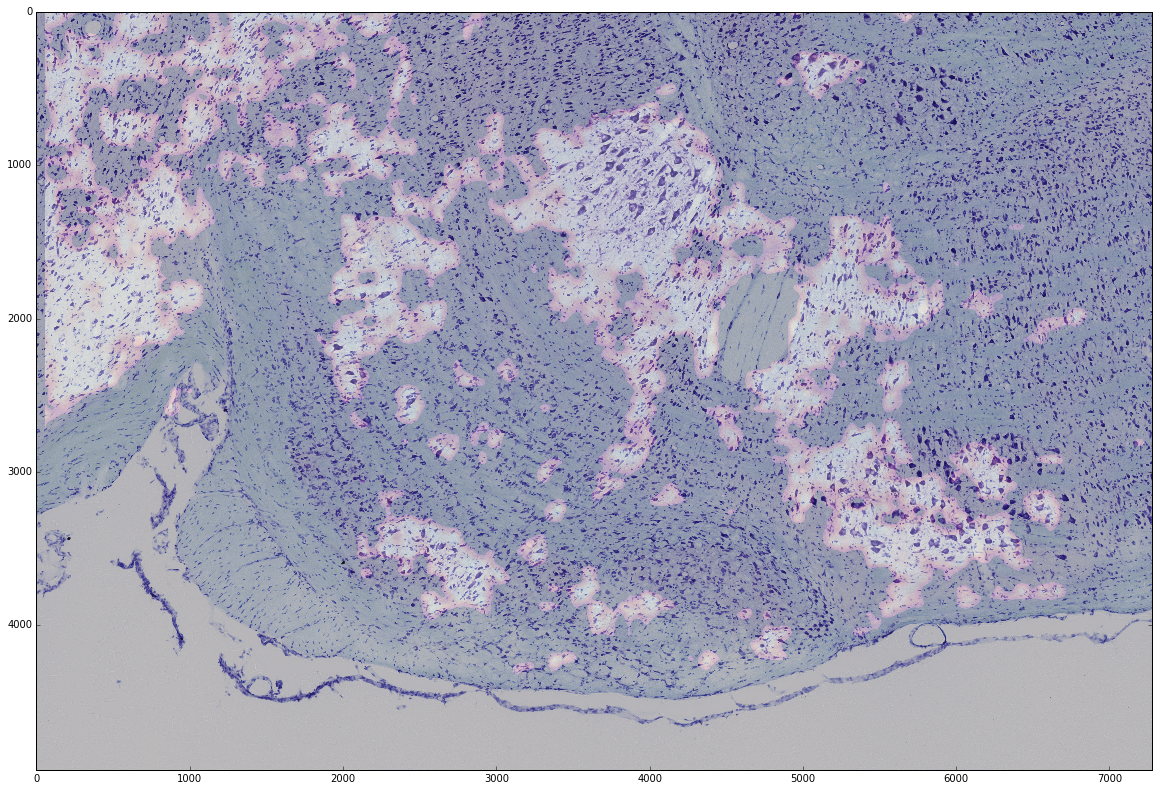

In [54]:
viz2 = alpha_blending(prob_map_viz[...,:3], img_as_ubyte(viz), .2, 1.,)
plt.figure(figsize=(20,20));
plt.imshow(viz2);